## Support Vector Machines (Linear)

You can think of an SVM classifier as fitting the widest possible street (represented by the parallel dashed lines) between the classes. Notice that adding more training instances “off the street” will not affect the decision
boundary at all: it is fully determined (or “supported”) by the instances located on the
edge of the street. These instances are called the support vectors

<img src="img/05_01.png">

### Soft Margin Classification

If we strictly impose that all instances be off the street and on the right side, this is
called *hard margin classification*. There are two main issues with hard margin classifi
cation. First, it only works if the data is linearly separable, and second it is quite sensitive to outliers. <br>
To avoid these issues it is preferable to use a more flexible model. The objective is to
find a good balance between keeping the street as large as possible and limiting the
margin violations (i.e., instances that end up in the middle of the street or even on the
wrong side). This is called *soft margin classification*.

<img src="img/05_02.png">

<br>

<img src="img/05_03.png">

>If your SVM model is overfitting, you can try regularizing it by
reducing C.

In [153]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64) # Iris-Virginica
svm_clf = Pipeline([
("scaler", StandardScaler()),
("linear_svc", LinearSVC(C=1, loss="hinge")),
])
svm_clf.fit(X, y)

In [2]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

>Unlike Logistic Regression classifiers, SVM classifiers do not out‐
put probabilities for each class.

The `LinearSVC` class regularizes the bias term, so you should center
the training set first by subtracting its mean. This is automatic if
you scale the data using the `StandardScaler`. Moreover, make sure
you set the `loss` hyperparameter to "hinge", as it is not the default
value. Finally, for better performance you should set the dual
hyperparameter to `False`, unless there are more features than
training instances.

## Nonlinear SVM Classification

Although linear SVM classifiers are efficient and work surprisingly well in many
cases, many datasets are not even close to being linearly separable. One approach to
handling nonlinear datasets is to add more features, such as polynomial features. in some cases this can result in a linearly separable dataset.

<img src="img/05_04.png">

In [164]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
X, y = make_moons()
polynomial_svm_clf = Pipeline([
("poly_features", PolynomialFeatures(degree=3)),
("scaler", StandardScaler()),
("svm_clf", LinearSVC(C=10, loss="hinge", max_iter=10000)),
])
polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge', max_iter=10000))])

In [152]:
def plot_decision_boundary(X, y, model):
    plt.figure(figsize=(8, 6))
    x1_max = X[:, :1].max()+0.5
    x1_min= X[:, :1].min()-0.5
    x2_max = X[:, 1:].max()+0.5
    x2_min = X[:, 1:].min()-0.5
    x, y2 = np.meshgrid(np.linspace(x1_min, x1_max, 1000), np.linspace(x2_min, x2_max, 1000))
    X_new = np.c_[x.ravel(),y2.ravel()]
    pred = model.predict(X_new)
    plt.contourf(x, y2, pred.reshape(x.shape), cmap=plt.cm.RdYlGn, alpha=0.2)

    X1_false = X[:, :1][y==0]
    X2_false = X[:, 1:][y==0]
    X1_true = X[:, :1][y==1]
    X2_true = X[:, 1:][y==1]
    plt.plot(X1_false, X2_false, "ro", label="0-Group")
    plt.plot(X1_true, X2_true, "gs", label="1-Group")

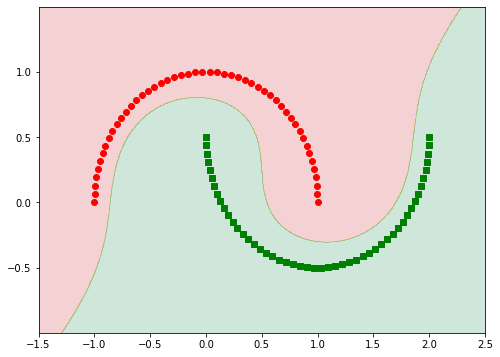

In [165]:
plot_decision_boundary(X, y, polynomial_svm_clf)

### Polynomial Kernel

When using SVMs you can apply an miraculous mathematical
technique called the *kernel trick*. It makes it possible to
get the same result as if you added many polynomial features, even with very highdegree polynomials, without actually having to add them. So there is no combinato‐
rial explosion of the number of features since you don’t actually add any features.

In [167]:
from sklearn.svm import SVC
X, y = make_moons()
poly_kernel_svm_clf = Pipeline([
("scaler", StandardScaler()),
("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
])
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

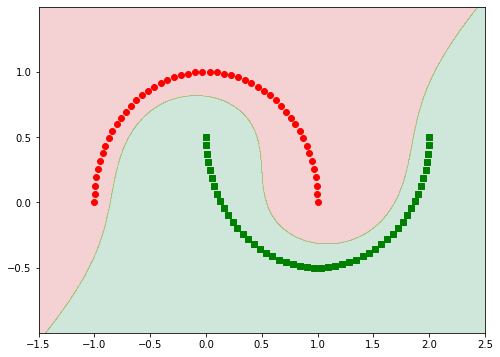

In [168]:
plot_decision_boundary(X, y, poly_kernel_svm_clf)

The hyperparameter `coef0` controls how much the model is influenced by highdegree polynomials versus low-degree polynomials.

### Adding Similarity Features

Another technique to tackle nonlinear problems is to add features computed using a
similarity function that measures how much each instance resembles a particular
landmark. For example, let’s take the one-dimensional dataset discussed earlier and
add two landmarks to it at $x_1 = –2$ and $x_1 = 1$. Next,
let’s define the similarity function to be the Gaussian Radial Basis Function (RBF)
with $\gamma = 0.3$.

<img src="img/05_05.png">

As we can see, it is now linearly
separable.

### Gaussian RBF Kernel
 

Just like the polynomial features method, the similarity features method can be useful
with any Machine Learning algorithm, but it may be computationally expensive to
compute all the additional features, especially on large training sets. However, once
again the kernel trick does its SVM magic: it makes it possible to obtain a similar
result as if you had added many similarity features, without actually having to add
them.

In [169]:
rbf_kernel_svm_clf = Pipeline([
("scaler", StandardScaler()),
("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

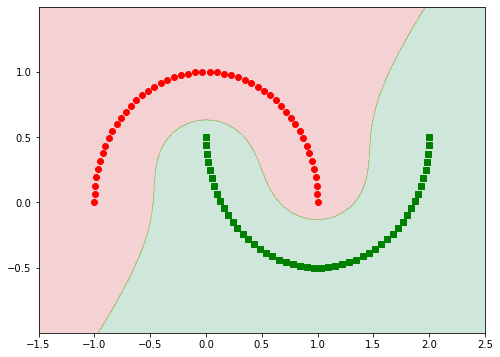

In [170]:
plot_decision_boundary(X, y, rbf_kernel_svm_clf)

## Computational Complexity

The `LinearSVC` class is based on the `liblinear` library, which implements an optimized
algorithm for linear SVMs. It does not support the kernel trick, but it scales almost linearly with the number of training instances and the number of features: its training
time complexity is roughly O(m × n). The algorithm takes longer if you require a very high precision. This is controlled by
the tolerance hyperparameter $\epsilon$ (called tol in Scikit-Learn).

The `SVC` class is based on the `libsvm` library, which implements an algorithm that sup‐
ports the kernel trick.2 The training time complexity is usually between $O(m^2 × n)$
and $O(m^3 × n)$. Unfortunately, this means that it gets dreadfully slow when the num‐
ber of training instances gets large. However, it scales
well with the number of features, especially with *sparse features*. In this case, the algorithm scales roughly with the
average number of nonzero features per instance.

<img src="img/05_06.png">

## SVM Regression

The SVM algorithm is quite versatile: not only does it sup‐
port linear and nonlinear classification, but it also supports linear and nonlinear
regression. The trick is to reverse the objective: instead of trying to fit the largest pos‐
sible street between two classes while limiting margin violations, *SVM Regression
tries to fit as many instances as possible on the street* while limiting margin violations
(i.e., instances off the street). The width of the street is controlled by a hyperparame‐
ter $\epsilon$.

<img src="img/05_07.png">

You can use Scikit-Learn’s `LinearSVR` class to perform linear SVM Regression.<br>
Same as regression, we can use Scikit-Learn’s `SVR` class to perform nonlinear SVM Regression.

## Mathematical Background

>Here, the bias term will be called $b$ and the feature weights vector
will be called $\mathbf{w}$. No bias feature will be added to the input feature vectors.

### Decision Function and Predictions

The linear `SVM` classifier model predicts the class of a new instance $\mathbf{x}$ by simply com‐
puting the decision function $$h = \mathbf{w}^T\mathbf{x} + b = w_1 x_1 + ⋯ + w_n x_n + b$$ if the result is positive,
the predicted class ŷ is the positive class (1), or else it is the negative class (0)

<img src="img/05_08.png">

The decision boundary is the set of points where the decision
function is equal to 0

### Training Objective

<img src = "img/05_09.png">

We are minimizing $\frac{1}{2}\mathbf{w}^T\mathbf{w}$, which is equal to $\frac{1}{2}||\mathbf{w}||^2$, rather than
minimizing $∥ \mathbf{w} ∥$. because it has a nice and simple derivative
(it is just $\mathbf{w}$) while $∥ \mathbf{w} ∥$ is not differentiable at $\mathbf{w = 0}$. Optimization
algorithms work much better on differentiable functions.

<img src = "img/05_10.png">

Here $\zeta^{i} \le0$ is the slack variable and measures how much the $i^{th}$ instance is allowed to violate the margin. 

### Quadratic Programming
The hard margin and soft margin problems are both convex quadratic optimization
problems with linear constraints. Such problems are known as Quadratic Program‐
ming (QP) problems. Many off-the-shelf solvers are available to solve QP problems
using a variety of techniques. The general
problem formulation is given by

<img src="img/05_11.png">

### The Dual Problem
Given a constrained optimization problem, known as the primal problem, it is possi‐
ble to express a different but closely related problem, called its dual problem. The sol‐
ution to the dual problem typically gives a lower bound to the solution of the primal
problem, but under some conditions it can even have the same solutions as the pri‐
mal problem. Luckily, the SVM problem happens to meet these conditions,6 so you
can choose to solve the primal problem or the dual problem; both will have the same
solution. 

<img src="img/05_12.png">

Once you find the vector $\hat{\alpha}$ that minimizes this equation (using a QP solver), you can
compute $\mathbf{\hat{w}}$ and $\hat{b}$ that minimize the primal problem by using

<img src="img/05_13.png">

### Kernelized SVM

Some common kernals are:

<img src="img/05_14.png">